In [1]:
import yfinance as yf
import pandas as pd
import datetime as dt
import matplotlib.pyplot as plt
import os
import requests
import time
import logging
import pytz
import datetime
import dateutil.parser

In [2]:
api_key = os.environ.get("POLYGON_API_KEY")
timezone = pytz.timezone("US/Eastern")

In [3]:
end = dt.datetime.now(timezone)
start = dt.datetime(year=end.year - 10, month=end.month, day=end.day, tzinfo=timezone)

# Busting the Gatekeepers (DIY Dividend Stock Analysis)

### Motivation in the Moment

Dividend stocks can be very profitable and can be used for when one is in a building mode or a sustaining mode.  They do need different tools to analyize them, however.

#### Building mode

Building mode is when one is using the stock market to save and build wealth.  Dividend stocks can be used to build wealth with DRIP (Dividend ReInvestment Program) or manually.  I have tried both ways and I like DRIP becuase it is automatic and I don't have to think about it.  Manually reivestmenting dividends means one must be on top of the cash flow.  This works well if one has nothing to do but watch money earn money but I do not have that privaledge.  I prefer automation when it comes to mananging my wealth.

#### Sustaning Mode

This mode is for collecting cash from a wealth position.  In terms of dividend stocks, this means turning off DRIP and collect the cash when the dividends pay out.

### Challenges of Analyzing Dividend Stocks

* Dividends are not all equal
* Time counts in the market


#### Dividends are not all equal

This is best explained with an example.  Let's get some code out to do this for us.

In [4]:
symbol="ABR"
initial_cash = 10000

We will be using ABR as our example as it is a good example for this challenge and we will be starting with 10 thousand in cash as that is a normal analysis starting point.

The below function goes out to Polygon and asks for ten years of dividend events for a given stock.  I have been using and improving this peice of code for at least two years now so it accounts for 80-90 percent of the issues that I have encountered.

In [5]:
def get_dividend_announcements(
    symbol: str, start: datetime.date, end: datetime.date
) -> list:
    uri_template = "https://api.polygon.io/v3/reference/dividends?ticker={symbol}&ex_dividend_date.gte={date}&limit=1000&order=asc&sort=ex_dividend_date&apiKey={apikey}"

    repeat = True
    date = start.strftime("%Y-%m-%d")
    uri = uri_template.format(apikey=api_key, date=date, symbol=symbol)
    last_date = start
    events = []
    while repeat and last_date <= end:
        try:
            r = requests.get(uri, timeout=(3, 10))
            r.raise_for_status()
            r = r.json()
            if "next_url" in r:
                uri = r["next_url"] + "&apiKey=" + api_key
                repeat = True
            else:
                repeat = False
            if "results" in r:
                if r["results"]:
                    last_date = dateutil.parser.parse(
                        r["results"][-1]["ex_dividend_date"]
                    ).date()
                    events.extend(r["results"])
                    logging.info(
                        f"size: {len(events)}, ex_dividend_date: {last_date}, symbol: {symbol}"
                    )

        except requests.exceptions.HTTPError as err:
            # This status code is singled out as it means my account has used up its alocated calls for the next minute.  This built in wait allows the function to gather anymore needed.
            if r.status_code != 429:
                logging.error(err)
                raise err
            logging.info(err)
            time.sleep(60)
            repeat = True
        except Exception as e:
            logging.error(repr(e))
            repeat = False
    return events

The `gather_dividends` function builds on top of the last function and creates a dataframe around the data.  This allows one to

In [6]:
def gather_dividends(symbol, start, end):
    dividend_events = get_dividend_announcements(symbol, start, end)
    events = pd.DataFrame.from_records(
        dividend_events, columns=dividend_events[0].keys()
    )
    # find outlier/special dividends.  Special dividends are like bonuses and cannot be counted on.  I remove them to get more of a pattern.
    special_dividends = events[events["frequency"] == 0].index
    events = events.drop(special_dividends)
    events["pay_date"] = pd.to_datetime(events["pay_date"])
    events["pay_date"] = events["pay_date"].dt.tz_localize(timezone)
    events = events.rename(columns={"pay_date": "Date", "ticker": "Symbol"})
    events = events.set_index("Date")
    return events

div_events = gather_dividends(symbol, start, end)

This just plots the dividend of the stock over the last ten years.  Nothing special here.

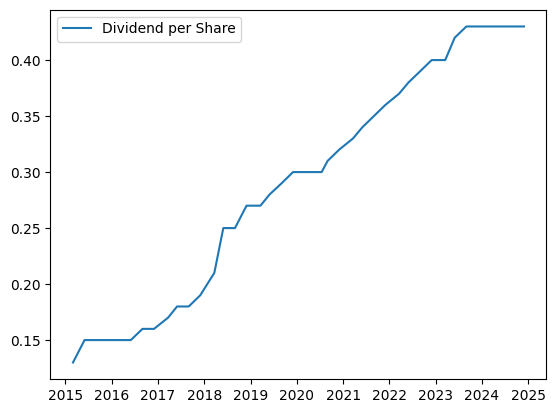

In [7]:
plt.plot(div_events.index, div_events["cash_amount"], label="Dividend per Share")
plt.title = f"Dividend per share of {symbol}"
plt.legend()
plt.show()

As one can see, the value of the dividend can vary a bit.  Here the value went up over the last ten years but 2018 was a rough year.  Most formulas for compounding interest do not account for variabilty.  This leads into the other challenge with dividend stocks.

### Time Counts in the Market

There is an old saying, "Time in the market, not timing the market".  What that means is staying in the market long term is better than trying to find the perfect time to enter the market and leave the market.  The chart above is a peice of proof for this nugget of wisdom.  This breaks down when analying dividend stocks because of the time difference between the ex-dividend date and pay date.  The ex-dividend date is the date that one must own the stock by to get the dividend on the pay date.  The pay date is the day when the money is paid out.  This can be up to one month after the ex-dividend date.  Yahoo finance has the dividend amount on the ex-dividend date but does not have the pay date.   This is why I used the Polygon data service as it includes the pay date.  This is important because part of the magic of the stock market is that the returns are compounding and compounding returns are very time sensitive.

### Tools in the Wild

I have found that most specialized tools for the stock market cost some money unless one has a nice stockbrokerage.  One of the many websites one can go to is [Seeking Alpha](https://seekingalpha.com/).  I would like to think the website has basic dividend stock tools but most of the content of the website is behind a paywall.  To be fair, it looks like there is a lot of value behind that paywall.

I like data and creating tools that store and messes with that data.  The concept that we will need to know about is **amortization**.  This is not new my any means so I am going to tackle it.

### Things to do first
 1. Download source code
2. Get a Polygon API_KEY at [Polygon.io](https://polygon.io/)
3. Set the API KEY to the environment variable `POLYGON_API_KEY`
4. Do the command `python -m venv ./.venv`
5. Activate the environment.  For me that would be `source <venv>/bin/activate`
6. `pip install -e .`

## The Analysis Code

This below code pulls in the historical dividend annoucements or events as I like to call them and figures out what the latest dividend per share is and what is the current frequency via the frequency map.

In [8]:
frequency_map = {12: "Monthly", 4: "Quarterly", 1: "Yearly"}
div_events = gather_dividends(symbol, start, end)
current_event = div_events.iloc[-1]
dividend_period = current_event["frequency"]
f"Latest dividend is {current_event["cash_amount"]}. Dividends are paid {frequency_map.get(current_event["frequency"])}"

'Latest dividend is 0.43. Dividends are paid Quarterly'

The next code block is a function that trims off any extra dividend events past the `end_date`

In [9]:
def trim_div_events(df, end):
    future_events = df[df.index > pd.to_datetime(end)].index
    return df.drop(future_events)

This codeblock retrieves the Open, Close, High, Low (OHLC) prices from (Finance Yahoo)[https://finance.yahoo.com/].  YFinance is a Python package that screen scrapes from (Finance Yahoo)[https://finance.yahoo.com/].  I created an account on the website just so it gets some value back from me.  It is a good and for the most part, free stock data repository.  Once the prices are downloaded, the index is converted from text to a timestamp in the US/Eastern timezone.  This can be adjusted at the top of this notebook.

In [10]:
ticker = yf.Ticker(symbol)
prices = ticker.history(start=start, end=end)
prices.index = pd.to_datetime(prices.index)
prices.index = prices.index.tz_convert(timezone)

## Creating a Dividend Snowball
Being able to figure out what a dividend stock investment will grow when the dividends are re-invested are an important part of the analysis process.  I will have comments in the code to point out what is happening.

In [41]:
def dividend_snowball(prices, div_events, initial_cash=10000):
    # The next two following lines makes sure the indexes align for both the dividend events and stock price data.
    # The index of the dividend events are already set to the pay date so the analysis can reflect how a DRIP would work.
    # Note that I am only interested in the dividend events right now.
    dividend_dates = div_events.index.unique().tolist()
    bought_stock = prices.loc[prices.index.isin(dividend_dates)]

    bought_stock = bought_stock.merge(
        div_events, left_index=True, right_index=True, how="left"
    )
    # The only two pieces of information that is needed is the cash amount of the dividend and the closing price.
    # The price can be other than the closing price and one would set that here.
    bought_stock = bought_stock[["Close", "cash_amount"]]

    # These two lines simulate the initial buy of a stock.
    initial_quantity = initial_cash / prices.iloc[0]["Close"]
    initial_total_div = initial_quantity * bought_stock.iloc[0]["cash_amount"]

    # This is setting up a list of pd.Series objects that will be used to keep track of the growing snowball.
    # This initial entry is based on the values calcuated above.
    columns = ["quantity", "total_dividend", "Date"]
    values = [
        pd.Series(
            [
                initial_quantity + initial_total_div / bought_stock.iloc[0]["Close"],
                initial_total_div,
                bought_stock.iloc[0].name,
            ],
            index=columns,
        )
    ]
    # I know using a for loop is a No-no using DataFrames.  Pandas does not make it easy to get ahold of the prior
    # row of data and I need that to know how to calculate the snowball.  Note the range, it starts with 1 instead of zero.
    for index in range(1, len(bought_stock)):
        current_row = bought_stock.iloc[index]
        dividend = current_row["cash_amount"]
        # Get the quantity from the last dividend event
        last_quantity = values[-1]["quantity"]
        # The amount of cash on the pay date depends on how much one already owns
        total_dividend = dividend * last_quantity
        # Then more shares are bought and added to the already owned shares.
        quantity = last_quantity + total_dividend / current_row["Close"]
        values.append(
            pd.Series([quantity, total_dividend, current_row.name], index=columns)
        )

    # Turn the list of pd.Series objects into a DataFrame so it can be visualized
    final_df = pd.DataFrame(values)
    final_df.set_index("Date", inplace=True)
    # Merge the Dataframe with the prices Dataframe to pull in the prices.
    final_df = prices[["Close"]].merge(
        final_df, left_index=True, right_index=True, how="outer"
    )

    # The next section of code fills back in the missing quantities.

    # This portion fills back in the initial quanity bought in the beginning
    final_df.iloc[0, final_df.columns.get_loc("quantity")] = initial_quantity
    quantity = final_df.iloc[0]["quantity"]
    final_df.loc[final_df.index < dividend_dates[0], "quantity"] = quantity

    # This loops through the dividend pay dates and fills in the quantities for that block of dates
    for index, start_date in enumerate(dividend_dates[:-1]):
        end_date = dividend_dates[index + 1]
        quantity = final_df.loc[start_date]["quantity"]
        date_filter = (start_date < final_df.index) & (final_df.index < end_date)
        try:
            # This sets the quantity for all the records that the date_filter selects
            final_df.loc[date_filter, "quantity"] = quantity
        except ValueError as ve:
            print(
                f"index {index}, start_date:{start_date}, end_date: {end_date}, quantity: {quantity}"
            )
            raise ve
    # This sets the quantity for the last set of days after the last dividend event.
    quantity = final_df.loc[dividend_dates[-1]]["quantity"]
    final_df.loc[final_df.index > dividend_dates[-1], "quantity"] = quantity
    return final_df

div_events = trim_div_events(div_events, end)
snowball = dividend_snowball(prices, div_events, initial_cash)
# This sets the position value
snowball["value"] = snowball["Close"] * snowball["quantity"]

In [42]:
def create_approach_summary(name, final_value, initial_cash, cash_in_bank):
    profit = final_value - initial_cash
    gain = profit / initial_cash * 100
    total_profit = profit + cash_in_bank
    total_gain = total_profit / initial_cash * 100
    return pd.Series(
        [
            name,
            round(final_value, 2),
            round(profit, 2),
            round(gain, 2),
            round(cash_in_bank, 2),
            round(total_profit, 2),
            round(total_gain, 2),
        ],
        index=[
            "Approach",
            "Final Market Amount($)",
            "Market Profit($)",
            "Market Gain(%)",
            "Cash Kept($)",
            "Total Profit($)",
            "Total Gain(%)",
        ],
    )


In [43]:
def dividend_keep_the_cash(prices, div_events, initial_cash):
    dividends_gathered = prices[["Close"]].merge(
        div_events[["cash_amount"]], left_index=True, right_index=True, how="outer"
    )
    dividends_gathered = dividends_gathered[["Close", "cash_amount"]]
    dividends_gathered["quantity"] = initial_cash / prices.iloc[0]["Close"]
    dividends_gathered["total_dividend"] = (
        dividends_gathered["cash_amount"] * dividends_gathered["quantity"]
    )
    dividends_gathered["value"] = (
        dividends_gathered["Close"] * dividends_gathered["quantity"]
    )
    return dividends_gathered

In [44]:
approaches = []

In [45]:
final_value = snowball.iloc[-1].value
approaches.append(create_approach_summary("Reinvest Dividends", final_value, initial_cash , 0.0))
dividends_gathered = dividend_keep_the_cash(prices, div_events, initial_cash)
final_value = dividends_gathered.iloc[-1].value
cash_in_bank = dividends_gathered.total_dividend.sum()
approaches.append(create_approach_summary("Keep the Cash", final_value, initial_cash, cash_in_bank))

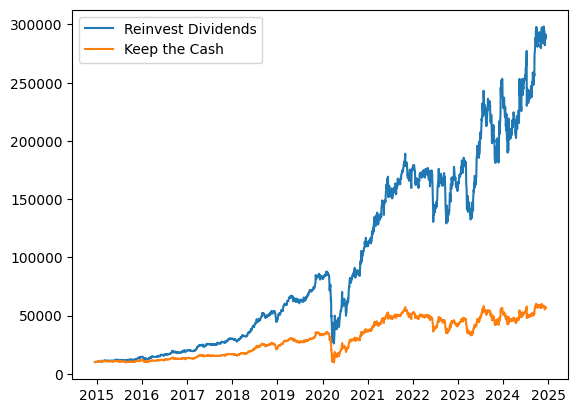

In [48]:
plt.plot(snowball.index, snowball['value'], label='Reinvest Dividends')
plt.plot(dividends_gathered.index, dividends_gathered['value'], label='Keep the Cash')
plt.title = f"Ten year performance {symbol}"
plt.legend()
plt.show()

In [49]:
pd.DataFrame(approaches).set_index("Approach")

,Final Market Amount($),Market Profit($),Market Gain(%),Cash Kept($),Total Profit($),Total Gain(%)
Approach,,,,,,
Reinvest Dividends,291241.19,281241.19,2812.41,0.0,281241.19,2812.41
Keep the Cash,57038.47,47038.47,470.38,45749.2,92787.67,927.88
